In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
import torch
from torch.utils.data import DataLoader

import sys

sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

# from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL
from ElectricPropertiesNN_PL import ElectricPropertiesNN_PL


## Load trained Models

In [3]:
models = pd.read_pickle("discrimination_performance.pkl")

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 100
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
original_dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
original_stats = pd.DataFrame.from_dict(original_dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
data_dir_name = "../../efish-physics-model/data/processed/data-2024_12_19-discrimination_dataset-capacitance"
raw_dataset = pd.read_pickle(f"{data_dir_name}/dataset.pkl")
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)
new_stats = pd.DataFrame.from_dict(dset.worms_properties_stats)[
    ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
]
dset.worms_properties_stats = original_dset.worms_properties_stats
dset.worms_properties = (
    dset.worms_properties[:] * new_stats.loc["std"].to_numpy()
    + new_stats.loc["mean"].to_numpy()
    - original_stats.loc["mean"].to_numpy()
) / original_stats.loc["std"].to_numpy()
dloader = DataLoader(dset, batch_size=batch_size, shuffle=False, drop_last=False, num_workers=12)

In [5]:
models

,rand_seed,lambda_RC,model_type,model,discrimination_performance
0,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [56.00000000000001, 53.0, 51.0, 44.0, 54.0..."
1,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [50.0, 56.00000000000001, 56.9999999999999..."
2,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [53.0, 56.00000000000001, 47.0, 56.9999999..."
3,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [43.0, 50.0, 55.00000000000001, 52.0, 57.9..."
4,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [38.0, 49.0, 52.0, 53.0, 43.0, 56.99999999..."
5,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [43.0, 45.0, 50.0, 55.00000000000001, 53.0..."
6,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [37.0, 49.0, 44.0, 44.0, 41.0, 54.0, 53.0,..."
7,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [59.0, 55.00000000000001, 55.0000000000000..."
8,113,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [41.0, 48.0, 54.0, 43.0, 56.99999999999999..."
9,113,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...,"{0: [46.0, 50.0, 46.0, 57.99999999999999, 63.0..."


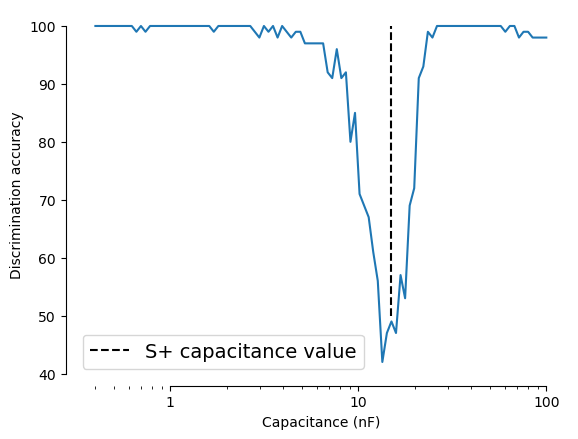

In [64]:
model_id = 11
pref_c_id = 65
plt.plot(raw_dataset["worms"]["capacitances"], models.iloc[model_id]["discrimination_performance"][pref_c_id])
select_C = raw_dataset["worms"]["capacitances"][pref_c_id]
plt.plot([select_C, select_C], [50, 100], "k--", label="S+ capacitance value")
plt.xscale("log")
sns.despine(offset=5, trim=True)
plt.xticks([1e-9, 1e-8, 1e-7], ["1", "10", "100"])
plt.xlabel("Capacitance (nF)")
plt.ylabel("Discrimination accuracy")
plt.legend(fontsize=14)    
plt.show()

In [58]:
raw_dataset["worms"]["capacitances"][pref_c_id]/1e-9

0.6986765286759985

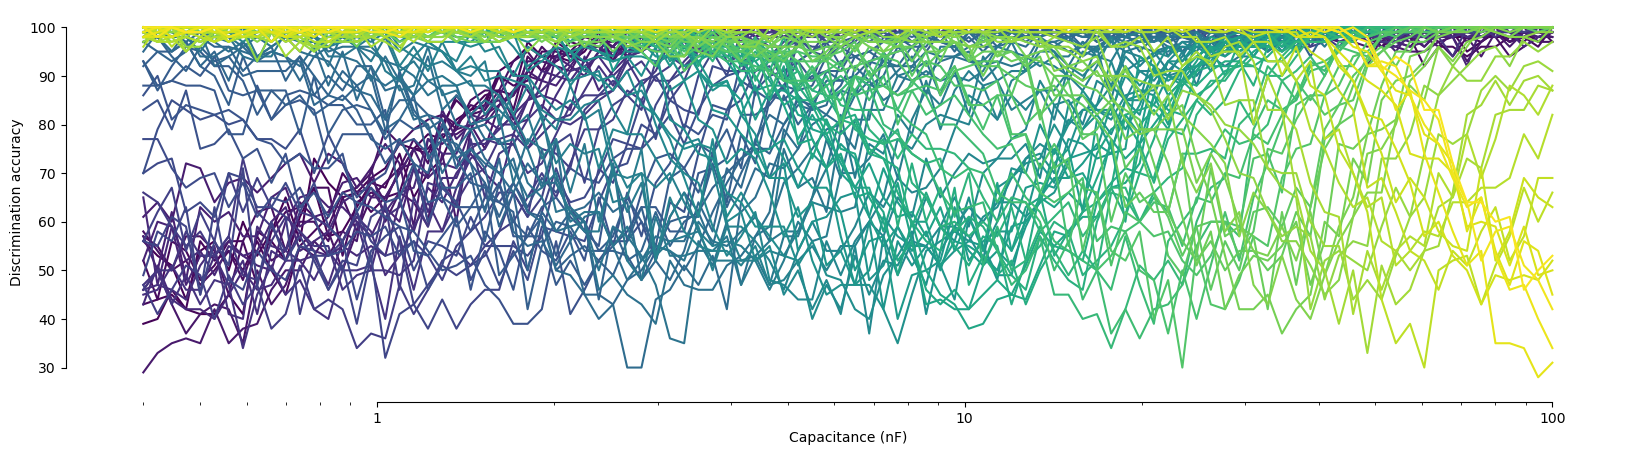

In [7]:
discrimination_performance = models.iloc[0]["discrimination_performance"]
plt.figure(figsize=(20, 5))
for k, v in discrimination_performance.items():
    plt.plot(raw_dataset["worms"]["capacitances"], v, c=plt.cm.viridis(k / len(raw_dataset["worms"]["capacitances"])))
plt.xscale("log")
sns.despine(offset=5, trim=True)
plt.xticks([1e-9, 1e-8, 1e-7], ["1", "10", "100"])
plt.xlabel("Capacitance (nF)")
plt.ylabel("Discrimination accuracy")
plt.show()

## Delta capacitance sensitivity

In [52]:
success_threshold = 80

def compute_delta_capacitances(dfrow, success_threshold=success_threshold, capacitances=raw_dataset["worms"]["capacitances"]):
    delta_capacitances = {}
    for k, vals in dfrow["discrimination_performance"].items():
        failure_ids = np.where(vals < success_threshold)[0][[0,-1]]
        failure_capacitances = capacitances[failure_ids]
        delta_capacitances[k] = np.abs(capacitances[pref_c_id] - failure_capacitances)
    dfrow["delta_capacitances"] = delta_capacitances
    return dfrow

models = models.apply(compute_delta_capacitances, axis=1)

In [53]:
def compute_delta_capacitances_stats(dfgroup):
    delta_capacitances = np.stack(dfgroup["delta_capacitances"].apply(lambda x: np.stack([v for _,v in x.items()])))
    return pd.Series({
        "mean": delta_capacitances.mean(0),
        "std": delta_capacitances.std(0),
    })

delta_capacitances_stats = models.groupby("model_type").apply(compute_delta_capacitances_stats)

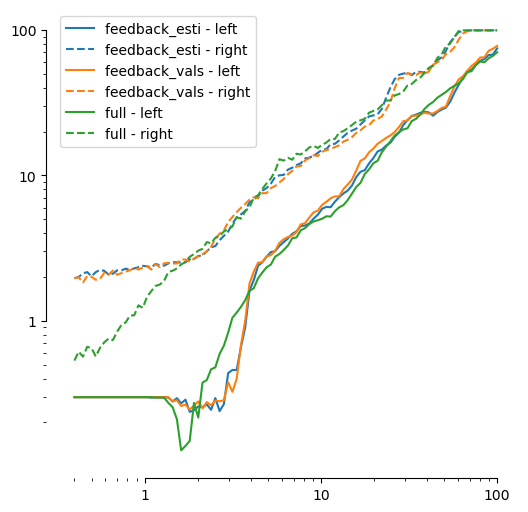

In [56]:
plt.figure(figsize=(6, 6))
for i, (model_type, row) in enumerate(delta_capacitances_stats.iterrows()):
    plt.plot(raw_dataset["worms"]["capacitances"], row["mean"][:,0], label=f"{model_type} - left", c=f"C{i}")
    # plt.fill_between(raw_dataset["worms"]["capacitances"], row["mean"][:,0] - row["std"][:,0], row["mean"][:,0] + row["std"][:,0], alpha=0.4, color=f"C{i}")
    plt.plot(raw_dataset["worms"]["capacitances"], row["mean"][:,1], label=f"{model_type} - right", c=f"C{i}", ls="--")
    # plt.fill_between(raw_dataset["worms"]["capacitances"], row["mean"][:,1] - row["std"][:,1], row["mean"][:,1] + row["std"][:,1], alpha=0.4, color=f"C{i}")

plt.xscale("log")
plt.xticks([1e-9, 1e-8, 1e-7], ["1", "10", "100"])
plt.yscale("log")
plt.yticks([1e-9, 1e-8, 1e-7], ["1", "10", "100"])
plt.legend()
sns.despine(offset=5, trim=True)
plt.show()